# Quantifying the overlap between TRASE and GADM 3.6 municipalities

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import shapely.wkb 
from shapely.ops import cascaded_union
from shapely.geometry import Polygon, Point, MultiPolygon
from tqdm import tqdm

## TRASE municipalities

In [2]:
trase = gpd.read_file('/Users/ikersanchez/Vizzuality/PROIEKTUAK/TRASE/work/data/BRAZIL_MUNICIPALITY.topo.json')

In [3]:
trase.drop(columns='id', inplace=True)

In [4]:
trase.head()

,name,geoid,geometry
0,FEIJÓ,BR-1200302,POLYGON ((-69.62153390813462 -8.21497511632667...
1,RIACHÃO DO BACAMARTE,BR-2512754,POLYGON ((-35.69843075280476 -7.21892064264695...
2,MANICORÉ,BR-1302702,POLYGON ((-60.72574314392932 -5.11336522362641...
3,DIANÓPOLIS,BR-1707009,POLYGON ((-46.55422173209713 -11.3773301857843...
4,PALMITAL,BR-4117800,POLYGON ((-52.45295035791459 -24.7462618266685...


## GADM 3.6 municipalities

In [5]:
gadm = gpd.read_file('/Users/ikersanchez/Vizzuality/PROIEKTUAK/TRASE/work/data/gadm36_BRA_shp/gadm36_BRA_2.shp')

In [6]:
gadm.drop(columns=['GID_0', 'NAME_0', 'GID_1', 'NAME_1', 'NL_NAME_1', 'VARNAME_2', 'NL_NAME_2',
                  'TYPE_2', 'ENGTYPE_2', 'CC_2', 'HASC_2'] , inplace=True)

In [7]:
gadm.head()

,GID_2,NAME_2,geometry
0,BRA.1.1_1,Acrelândia,POLYGON ((-67.16084290000001 -9.98259926000000...
1,BRA.1.2_1,Assis Brazil,"POLYGON ((-69.56517792 -10.95549774, -69.56603..."
2,BRA.1.3_1,Brasiléia,"POLYGON ((-69.4235611 -10.92717266, -69.419380..."
3,BRA.1.4_1,Bujari,"POLYGON ((-67.94033813 -9.33721924, -67.944107..."
4,BRA.1.5_1,Capixaba,"POLYGON ((-68.00377655 -10.65377045, -68.00351..."


## Quantifying the overlap

In [8]:
def rtree_intersect(gadm, trase):
    fraction  = []
    gid_2 = []
    name_2 = []
    
    sindex = gadm.sindex
    # We iterate over municipalities in trase     
    for n, municipality in enumerate(trase.geometry):
        
        # Fix invalid shapes
        if municipality.is_valid == False:
            municipality = municipality.simplify(0.016, preserve_topology=True)
            if municipality.is_valid == False:
                municipality = cascaded_union(municipality)
            
        # gadm areas that intersect with the municipality bound
        possible_matches_index = list(sindex.intersection(municipality.bounds))
        possible_matches = gadm.iloc[possible_matches_index]

        frac  = []
        for i in range(len(possible_matches_index)):
            geom = possible_matches.geometry.iloc[i]
            # Intersection area
            int_area = geom.intersection(municipality).area
            # Residual area
            res_area = (geom.area - int_area) + (municipality.area - int_area)
            # Total area
            tot_area = int_area + res_area
    
            frac.append(int_area/tot_area)
    
        frac = np.array(frac)
        
        matches = possible_matches.iloc[np.where(frac == frac.max())]
        
        gid_2.append(matches.get('GID_2').iloc[0])
        name_2.append(matches.get('NAME_2').iloc[0])
        fraction.append(frac.max())
        
    return gid_2, name_2, fraction

In [9]:
gid_2, name_2, fraction = rtree_intersect(gadm, trase)

In [10]:
trase['GID_2'] = gid_2
trase['NAME_2'] = name_2
trase['match_fraction'] = fraction

In [11]:
trase.head()

,name,geoid,geometry,GID_2,NAME_2,match_fraction
0,FEIJÓ,BR-1200302,POLYGON ((-69.62153390813462 -8.21497511632667...,BRA.1.8_1,Feijó,0.785910
1,RIACHÃO DO BACAMARTE,BR-2512754,POLYGON ((-35.69843075280476 -7.21892064264695...,BRA.15.160_1,Riacho,0.954083
2,MANICORÉ,BR-1302702,POLYGON ((-60.72574314392932 -5.11336522362641...,BRA.4.37_1,Manicore,0.997462
3,DIANÓPOLIS,BR-1707009,POLYGON ((-46.55422173209713 -11.3773301857843...,BRA.27.46_1,Dianopolis,0.989655
4,PALMITAL,BR-4117800,POLYGON ((-52.45295035791459 -24.7462618266685...,BRA.16.252_1,Palmital,0.973342


**Distribution of the accuracy**

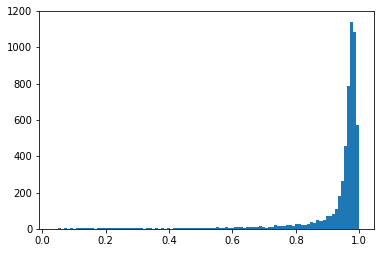

In [12]:
hist = plt.hist(np.array(fraction), bins= 100)

**85 % of the municipalities overlap with an accuracy greater than 90 %**

In [13]:
len(trase[trase['match_fraction'] > 0.9])/len(trase)*100

85.67834681042228

and 74 % of the municipalities have an accuracy greater than 95 %

In [14]:
len(trase[trase['match_fraction'] > 0.95])/len(trase)*100

73.54896675651392

## Some examples

In the next figures we show a few examples of the overlap between municipalities with different accuracies.

In red we display GADM 3.6 polygons and overlaying, in blue, the polygons from TRASE.

In [15]:
def display_overlap(n):
    sindex = gadm.sindex
    municipality = trase.geometry[n]
    possible_matches_index = list(sindex.intersection(municipality.bounds))
    possible_matches = gadm.iloc[possible_matches_index]

    fraction = []
    for i in range(len(possible_matches_index)):
        geom = possible_matches.geometry.iloc[i]
        # Intersection area
        int_area = geom.intersection(municipality).area
        # Residual area
        res_area = (geom.area - int_area) + (municipality.area - int_area)
        # Total area
        tot_area = int_area + res_area
    
        fraction.append(int_area/tot_area)

    fraction = np.array(fraction)
    possible_matches.iloc[np.where(fraction == fraction.max())]


    fig, ax = plt.subplots(figsize=[10,10])
    ax.set_aspect('equal')

    #possible_matches.iloc[:].plot(ax=ax, color='r', edgecolor='k', alpha=0.5)
    possible_matches.iloc[np.where(fraction == fraction.max())].plot(ax=ax, edgecolor='k', alpha=0.75, color="#ffe1e6")
    trase.iloc[n:(n+1)].plot(ax=ax, edgecolor='k', alpha=0.75, color="#c3e1ff")

**Municipality with 30 % of accuracy**

With this accuracy we have many examples as the one shown below. 
In GADM 3.6 we find two separated polygons with the same ID (BRA.21.264_1 in this case), while in TRASE these polygons belong to two different
municipalities.

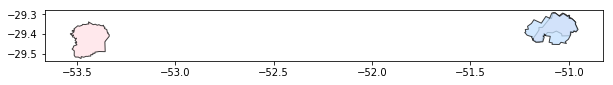

In [16]:
display_overlap(4003)

Two different polygons in TRASE

In [17]:
trase[trase['GID_2'] == 'BRA.21.264_1']

,name,geoid,geometry,GID_2,NAME_2,match_fraction
1304,NOVA PALMA,BR-4313102,POLYGON ((-53.4402660828629 -29.33876361467055...,BRA.21.264_1,Nova Palma,0.533038
4003,NOVA PETRÓPOLIS,BR-4313201,POLYGON ((-51.19671253716677 -29.4094942999360...,BRA.21.264_1,Nova Palma,0.310385


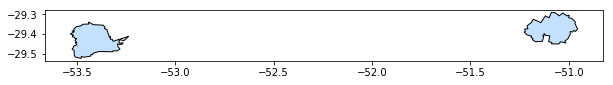

In [18]:
trase[trase['GID_2'] == 'BRA.21.264_1'].plot(figsize=(10,10), edgecolor='k', color="#c3e1ff")

**Municipality with 40 % of accuracy**

With this accuracy we have many examples as the one shown below. In GADM 3.6 we find a single polygon, while in TRASE this polygon has been splitted into two different municipalities.

In [19]:
trase['match_fraction'].iloc[1505]

0.4031279374800938

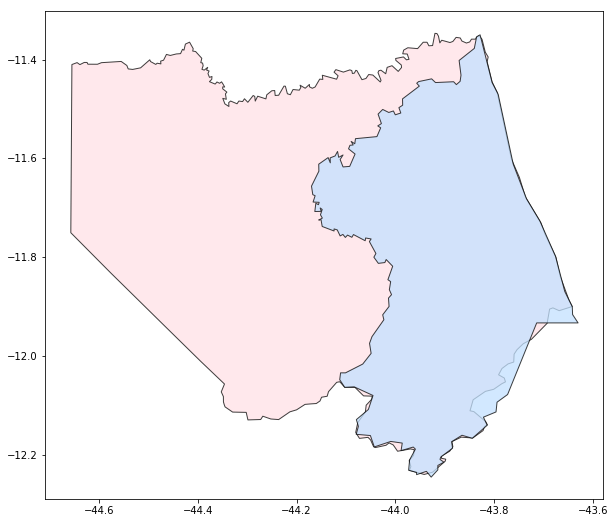

In [20]:
display_overlap(1505)

Two different polygons in TRASE

In [21]:
trase[trase['GID_2'] == 'BRA.5.113_1']

,name,geoid,geometry,GID_2,NAME_2,match_fraction
151,COTEGIPE,BR-2909406,POLYGON ((-43.83690880326785 -11.3529211649868...,BRA.5.113_1,Cotegipe,0.581043
1505,WANDERLEY,BR-2933455,POLYGON ((-43.83690880326785 -11.3529211649868...,BRA.5.113_1,Cotegipe,0.403128


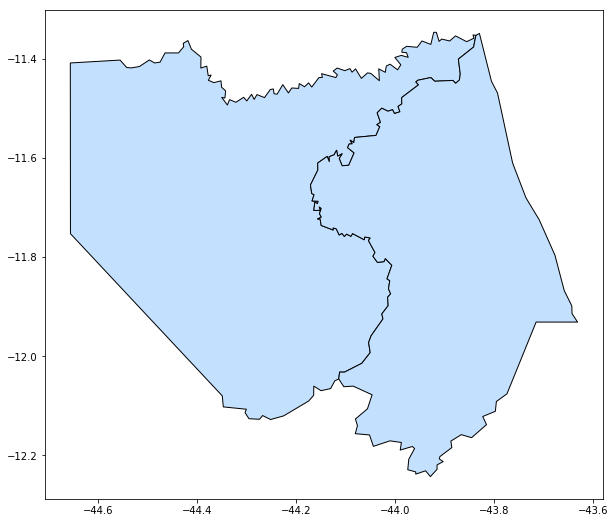

In [22]:
trase[trase['GID_2'] == 'BRA.5.113_1'].plot(figsize=(10,10), edgecolor='k', color="#c3e1ff")

**Municipality with 80 % of accuracy**

Above this accuracy we find a one-to-one relation between  GADM and Trase.

In [23]:
trase['match_fraction'].iloc[0]

0.785909841647496

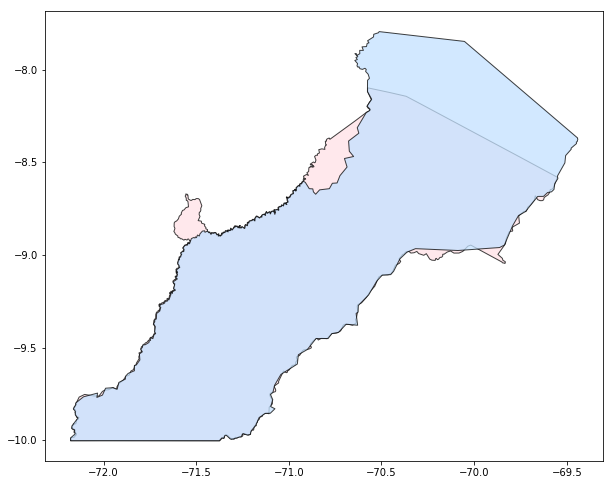

In [24]:
display_overlap(0)

**Municipality with 90 % of accuracy**

In [25]:
trase['match_fraction'].iloc[23]

0.9039924955742447

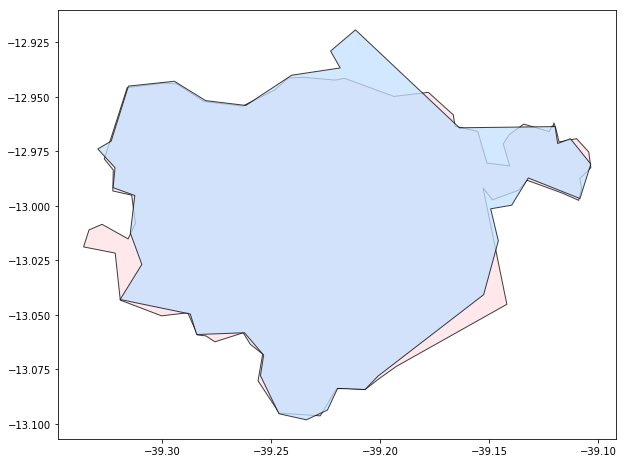

In [26]:
display_overlap(23)

**Municipality with 99 % of accuracy**

In [27]:
trase['match_fraction'].iloc[2]

0.997462194209166

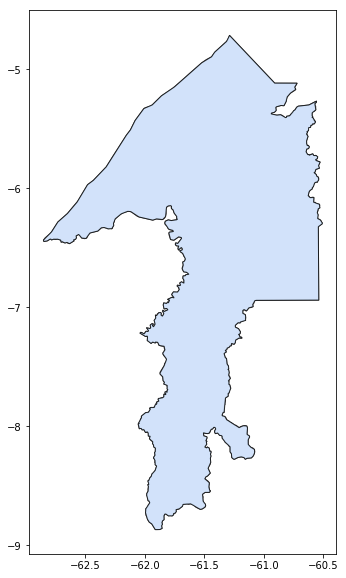

In [28]:
display_overlap(2)